In [1]:
import os
from collections import defaultdict

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'

from adjustText import adjust_text

from Bio import SeqIO

from scipy import stats
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [2]:
datadir = '../data/dnaPipeTE-out'
dnapipete_data = {sp: f'{datadir}/{sp}/Counts.txt' for sp in os.listdir(datadir)}

In [3]:
def read_counts(countfile):
    count_df = pd.read_csv(countfile, sep='\t', header=None, names=['teclass', 'readcount'])
    return count_df

def count_finz_znf(species):
    count = 0
    with open('../data/seqs/cypriniformes_augustus_finz.fa') as infile:
        for line in infile:
            if line.startswith(f'>{species}'):
                count += 1
    return count

def count_finz_exons(species):
    count = 0
    with open(f'../data/blast-out/{species}_finz_locs.out') as infile:
        for line in infile:
            count += 1
    return count

def count_znf_hits(species):
    count = 0
    with open(f'../data/blast-out/{species}_znf_locs.out') as infile:
        for line in infile:
            count += 1
    return count

def age_proportions():
    divdict = defaultdict(list)
    for species in dnapipete_data.keys():
        landscape_df = pd.read_csv(f'../data/dnaPipeTE-out/{species}/reads_landscape', 
                                   sep=r'\s+', 
                                   header=None, 
                                   names=['identity', 'tename', 'tefam', 'teclass'])
        landscape_df['divergence'] = 100 - landscape_df.identity
        step = 5
        total = landscape_df.tename.count()
        divdict['species'].append(species)
        for i in range(0, int(np.ceil(max(landscape_df.divergence)))+1+step, step):
            divdict[f'lt_{i}'].append(landscape_df.loc[landscape_df.divergence <= i, 'tename'].count()/total)
            divdict[f'gt_{i}'].append(landscape_df.loc[landscape_df.divergence > i, 'tename'].count()/total)
    return pd.DataFrame.from_dict(divdict)
    


In [7]:
count_dfs = []
for sp, val in dnapipete_data.items():
    count_df = read_counts(val)
    count_df['species'] = sp
    count_df['finz_znf'] = count_finz_znf(sp)
    count_df['finz_exons'] = count_finz_exons(sp)
    count_df['znf_hits'] = count_znf_hits(sp)
    count_dfs.append(count_df)

count_df = pd.concat(count_dfs)
count_df = count_df.pivot_table(index=['species', 'finz_exons', 'finz_znf', 'znf_hits'], 
                                columns='teclass', 
                                values='readcount') \
    .sort_values('finz_znf') \
    .reset_index()
count_df['Unknown'] = count_df.na + count_df.others
count_df = count_df.drop(['Others', 'Tandem_repeats', 'na', 'others', 'rRNA', 'MITE', 'Simple_repeat'], axis=1)
count_df['interspersed'] = count_df.DNA + count_df.LTR + count_df.LINE + count_df.SINE + count_df.Helitron + count_df.Unknown
    
for teclass in ['DNA', 'Helitron', 'LINE', 'LTR', 'SINE', 'Low_Complexity', 'Satellite', 'Unknown', 'interspersed', 'Total']:
    count_df[teclass] = count_df[teclass]/count_df['Total']*100

with open('../data/species_genomes.txt') as infile:
    hiqual = [line.split()[0] for line in infile]
count_df = count_df.loc[count_df.species.isin(hiqual)]
print(count_df)
count_df = count_df.loc[~count_df.species.str.startswith('Chanos')]
count_df = count_df.loc[~count_df.species.str.startswith('Triplophysa')]

teclass                          species  finz_exons  finz_znf  znf_hits  \
0                   Triplophysa_tibetana           0         0      7459   
1                    Triplophysa_dalaica           0         0      6336   
2                          Chanos_chanos           0         0      4536   
3                 Triplophysa_siluroides           1         0      6513   
4                     Danionella_dracula           3         4      8474   
5                 Danionella_translucida           5         9      6400   
6            Hypophthalmichthys_molitrix          99        16     14368   
7                          Danio_choprai          92        64      6583   
8                    Danio_jaintianensis         111        93      7129   
9                          Danio_tinwini         150        96      8636   
10                    Leuciscus_waleckii         196       106     14638   
11                   Puntigrus_tetrazona         204       135      8042   
12          

SpearmanrResult(correlation=0.6497536945812806, pvalue=0.00013647985775624383)


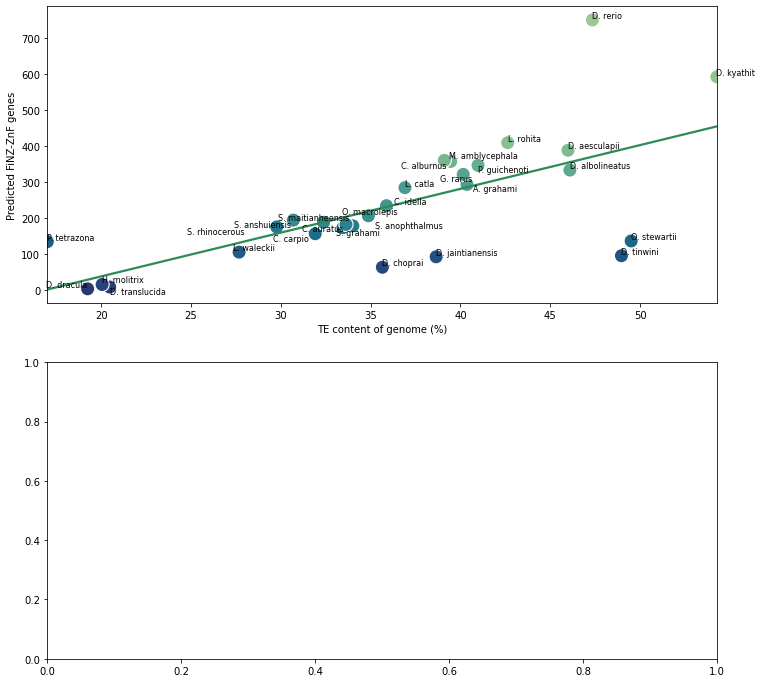

In [8]:
column = 'interspersed'
fig, ax = plt.subplots(figsize=(12, 12), nrows=2)

sns.regplot(data=count_df, 
            x=column, 
            y='finz_znf',
            scatter=False,
            ci=None,
            color='seagreen',
            ax=ax[0])

sns.scatterplot(data=count_df, 
                x=column, 
                y='finz_znf',
                hue='species',
                palette='crest_r',
                s=200,
                ax=ax[0])

# ax[0].set_xlim(19, 56)
# ax[0].set_ylim(-50, 850)
ax[0].get_legend().remove()
ax[0].set_xlabel('TE content of genome (%)')
ax[0].set_ylabel('Predicted FiNZ-ZnF genes')

labels = []
for row in count_df.iterrows():
    label = row[1]['species'].split('_')[0][0] +'. '+ row[1]['species'].split('_')[1]
    labels.append(ax[0].text(row[1][column], row[1]['finz_znf'], 
                             label, 
                             fontsize=8, 
                             va='center', 
                             ha='center'))
adjust_text(labels)

pval = stats.spearmanr(count_df[column], 
                       count_df['finz_znf'])
print(pval)
# ax[0].text(x=22, 
#         y=700, 
#         s=f'rho = {pval[0]:.3f}\np = {pval[1]:.2e}',
#         fontsize=8)

# sns.regplot(data=pic_df, 
#             x=f'pic.{column}', 
#             y='pic.finz_exons',
#             scatter=False,
#             ci=None,
#             color='seagreen',
#             ax=ax[1])

# sns.scatterplot(data=pic_df, 
#                 x=f'pic.{column}', 
#                 y='pic.finz_znf',
#                 color='teal',
#                 s=200,
#                 ax=ax[1])


# ax[1].set_xlim(-70, 115)
# ax[1].set_xlabel('Contrast in TE content')
# ax[1].set_ylabel('Contrast in FiNZ-ZnF copy number')

# picpval = stats.spearmanr(pic_df[f'pic.{column}'], 
#                        pic_df['pic.finz_znf'])

# ax[1].text(x=-50, 
#            y=2000, 
#            s=f'rho = {picpval[0]:.3f}\np = {picpval[1]:.2e}',
#            fontsize=8)

# sns.despine()
# plt.show()
# fig.savefig('../figs/finz_znf_corr.pdf', bbox_inches='tight', dpi=300)

In [6]:
phylogeny_order = ['Chanos_chanos', 
                   'Triplophysa_dalaica', 'Triplophysa_tibetana', 'Triplophysa_siluroides', 
                   'Danio_choprai', 'Danio_jaintianensis', 'Danio_tinwini', 'Danio_kyathit', 'Danio_rerio', 'Danio_aesculapii', 'Danio_albolineatus',
                   'Danionella_translucida', 'Danionella_dracula',
                   'Leuciscus_waleckii', 
                   'Hypophthalmichthys_molitrix', 'Megalobrama_amblycephala', 'Culter_alburnus', 'Anabarilius_grahami', 'Ctenopharyngodon_idella',
                   'Labeo_catla', 'Labeo_rohita',
                   'Onychostoma_macrolepis', 'Oxygymnocypris_stewartii', 
                   'Sinocyclocheilus_grahami', 'Sinocyclocheilus_rhinocerous', 'Sinocyclocheilus_anshuiensis', 
                   'Carassius_auratus', 'Cyprinus_carpio']
nfinz = [[0]]
for sp in phylogeny_order[1:]:
    nfinz.append(list(count_df.loc[count_df.species == sp, 'finz_znf']))
nfinze = [[0]]
for sp in phylogeny_order[1:]:
    nfinze.append(list(count_df.loc[count_df.species == sp, 'finz_exons']))
    
plt.figure(figsize=(1,10))
hm = sns.heatmap(nfinz, cmap='crest_r', annot=True, fmt='d', yticklabels=phylogeny_order)
plt.figure(figsize=(1,10))
hm = sns.heatmap(nfinze, cmap='crest_r', annot=True, fmt='d', yticklabels=phylogeny_order)

plt.savefig('../figs/nfinz_heatmap.pdf', dpi=300)
plt.show()

/Users/jonwells/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


IndexError: Inconsistent shape between the condition and the input (got (28, 1) and (28,))

<Figure size 72x720 with 0 Axes>

A possible explanation for some of the noise in the correlation is genome assembly quality. Since the finz-znfs are normally present on specific, highly repetitive chromosomes, it is possible that low numbers of predicted genes could be due to collapsing or fragmentation of these regions. To test this, we will look at the correlation between N50 and finz count.

In [ ]:
def calc_N50(genomefile):
    contiglens = []
    for record in SeqIO.parse(genomefile, 'fasta'):
        contiglens.append(len(record.seq))
    contiglens = sorted(contiglens, reverse=True)
    gsize = sum(contiglens)
    i, currentsize = 0, 0
    while currentsize <= gsize*0.5:
        currentsize += contiglens[i]
        i += 1
    return contiglens[i]

with open('../data/species_genomes.txt') as infile:
    genomes = {line.split()[0]: f'/Users/jonwells/Genomes/Cypriniformes/{line.split()[1]}' for line in infile}
genomes.pop('Chanos_chanos')


n50s = []
for species, genomefile in genomes.items():
    n50s.append((species, calc_N50(genomefile)))
n50_df = pd.DataFrame(n50s, columns=['species', 'N50'])
# n50_df = n50_df.merge(count_df, on='species')
print(n50_df.head())

In [ ]:
n50_df = n50_df[['species', 'N50']]
n50_df = n50_df.merge(count_df, on='species')
print(n50_df)
n50_df.to_csv('../data/finz_te_counts.txt', sep='\t', header=True, index=False)

In [15]:
# print(n50_df.loc[n50_df.species.str.startswith('Triplophysa')])

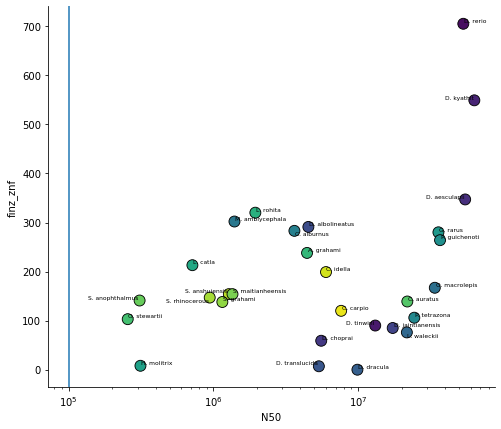

SpearmanrResult(correlation=0.24658209326093072, pvalue=0.19722603760185473)
SpearmanrResult(correlation=0.24088669950738908, pvalue=0.2081067505065501)


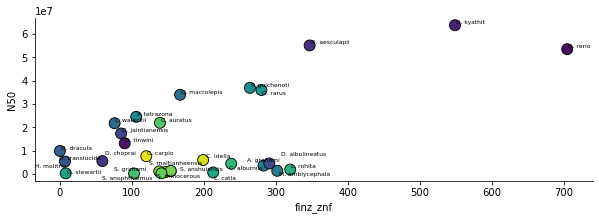

SpearmanrResult(correlation=0.24658209326093072, pvalue=0.19722603760185473)


In [22]:
min_N50 = 1e05
column = 'finz_znf'

fig, ax = plt.subplots(figsize=(8, 7)) 
sns.scatterplot(data=n50_df, 
                x='N50', 
                y=column,
                hue='species',
                palette='viridis_r',
                edgecolor='k',
                s=120,
                ax=ax)
ax.axvline(x=min_N50)
ax.set_xscale('log')
ax.get_legend().remove()

labels = []
for row in n50_df.iterrows():
    label = row[1]['species'].split('_')[0][0] +'. '+ row[1]['species'].split('_')[1]
    labels.append(ax.text(row[1]['N50'], row[1][column], label, size=6, va='center', ha='center'))
adjust_text(labels)

sns.despine()
plt.show()
print(stats.spearmanr(n50_df.loc[n50_df['N50'] >= min_N50].N50, n50_df.loc[n50_df['N50'] >= min_N50][column]))
print(stats.spearmanr(n50_df.loc[n50_df['N50'] >= min_N50].N50, n50_df.loc[n50_df['N50'] >= min_N50].interspersed))

fig, ax = plt.subplots(figsize=(10, 3)) 
sns.scatterplot(data=n50_df.loc[n50_df['N50'] >= min_N50], 
                y='N50', 
                x=column,
                hue='species',
                palette='viridis_r',
                edgecolor='k',
                s=120,
                ax=ax)
ax.get_legend().remove()

labels = []
for row in n50_df.loc[n50_df['N50'] >= min_N50].iterrows():
    label = row[1]['species'].split('_')[0][0] +'. '+ row[1]['species'].split('_')[1]
    labels.append(ax.text(row[1][column], row[1]['N50'], label, size=6, va='center', ha='center'))
adjust_text(labels)

sns.despine()
plt.show()

print(stats.spearmanr(n50_df.loc[n50_df['N50'] >= min_N50].N50, n50_df.loc[n50_df['N50'] >= min_N50][column]))

In [23]:
print(n50_df.loc[n50_df['N50'] >= min_N50].reset_index().species)
n50_df.loc[n50_df['N50'] >= min_N50].reset_index()[['species']].to_csv('../data/n50_gt5e05.txt', header=False, index=False)

0                     Cyprinus_carpio
1             Ctenopharyngodon_idella
2        Sinocyclocheilus_anshuiensis
3        Sinocyclocheilus_rhinocerous
4            Sinocyclocheilus_grahami
5     Sinocyclocheilus_maitianheensis
6       Sinocyclocheilus_anophthalmus
7                   Carassius_auratus
8            Oxygymnocypris_stewartii
9                 Anabarilius_grahami
10                       Labeo_rohita
11                        Labeo_catla
12        Hypophthalmichthys_molitrix
13                  Gobiocypris_rarus
14         Paracanthobrama_guichenoti
15                Puntigrus_tetrazona
16                    Culter_alburnus
17           Megalobrama_amblycephala
18             Onychostoma_macrolepis
19                 Leuciscus_waleckii
20                 Danionella_dracula
21             Danionella_translucida
22                 Danio_albolineatus
23                Danio_jaintianensis
24                      Danio_choprai
25                   Danio_aesculapii
26          